In [59]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
%matplotlib inline

# Flattening

In [3]:
files= np.loadtxt('l1data.txt', dtype='str')
darks = np.loadtxt('darksl1.txt', dtype='str')
allimagedata = [fits.getdata(f) for f in files]
darksimages = [fits.getdata(f) for f in darks]
darksmedia = np.median(darksimages, axis=0)
flatteddatal1 = allimagedata - darksmedia

We plot an example one

<matplotlib.colorbar.Colorbar instance at 0x7fd1c0a848c0>

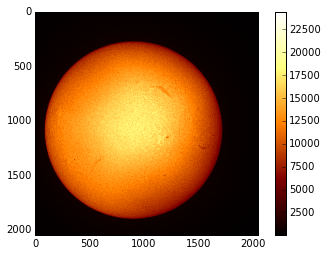

In [4]:
plt.imshow(flatteddatal1[0],cmap='afmhot')
plt.colorbar()

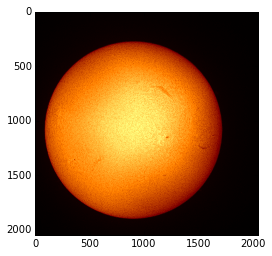

In [5]:
plt.imshow(allimagedata[0],cmap='afmhot')

We can make a fit file with the new flatten data. 

In [8]:
#for i in range(109):
#    fits.writeto(files[i]+'processed',flatteddatal1[i],header=fits.open(files[i])[0].header)
#onefit=fits.getdata('imoa_06563_l1_20160126_12284100_b1.ftsprocessed')
#headerone=fits.open('imoa_06563_l1_20160126_12284100_b1.ftsprocessed')[0].header
#plt.imshow(onefit,cmap='afmhot')
#plt.colorbar()
#headerone

# Brillance

We create the median of all the flatted data.

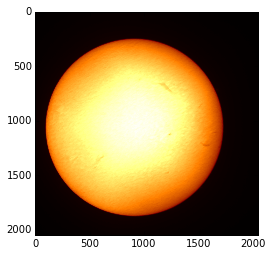

In [9]:
medianflattedl1 = np.median(flatteddatal1, axis=0)
plt.imshow(medianflattedl1,cmap='afmhot')

We can now mask to get only the disk of the Sun. For l1 we decide a threshold of 900 *adu*. We create the mask and put to zero all below 900. The mask looks like

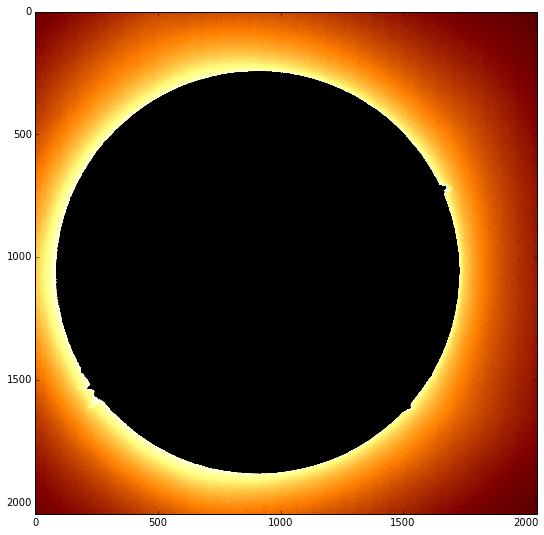

In [38]:
maskvalue = 1000
maskl1 = medianflattedl1 < maskvalue
maskedl1=(np.where(maskl1,1,0))*medianflattedl1
plt.figure(num=None, figsize=(10, 9))
plt.imshow(maskedl1,cmap='afmhot')

The resulting masked image looks like:

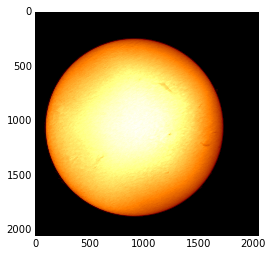

In [39]:
maskl1 = medianflattedl1 < maskvalue
maskedl1=(np.where(maskl1,0,1))*medianflattedl1
plt.imshow(maskedl1,cmap='afmhot')

Now we calculate the total of the masked image to get the luminosity of the Sun:
    

In [40]:
totall1 = np.sum(maskedl1)
print(totall1)

27624313625.0


# Brillance Calibration

Above we have found the total luminosity in $H\alpha$ from the Sun disk. We know that the total luminosity of the Sun in $H\alpha$ should be 1.59 W/m/nm. With this we can calibrate each pixel.

In [41]:
call1 = 1.59/totall1
maskedl1 = maskedl1 * call1
call1=call1 * flatteddatal1

We can plot one to verify:

<matplotlib.colorbar.Colorbar instance at 0x7fd147df7ef0>

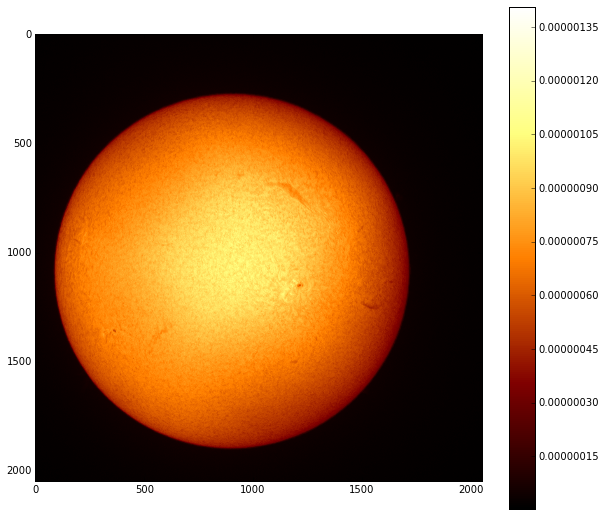

In [42]:
plt.figure(num=None, figsize=(10, 9))
plt.imshow(call1[0],cmap='afmhot')
plt.colorbar()

## Limb Darkening

The first order expression of Limb Darkening is:

$$\frac{I(\phi)}{I(0)}= 1+ A_1 \, (1- \cos(\phi))$$

where $\phi$ represents the angle. 

We can see this in our dataset by plotting the values of the intensity of the Sun for a given x value. We select 900. We use the masked image where everything outside the Sun is 0. We express the index as a function of the angle from -90 to 90 degrees. 

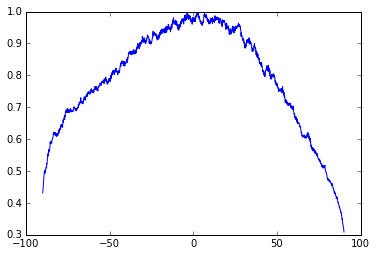

In [111]:
sunmask = maskedl1[900]  != 0
sundiskmaksedl1 = maskedl1[1000][sunmask]
xsundisk = np.linspace(-90, 90, len(sundiskmaksedl1))
plt.plot( xsundisk, sundiskmaksedl1/np.max(sundiskmaksedl1))

We can plot the function we need to fit for an arbitrary value for A and then fit. 

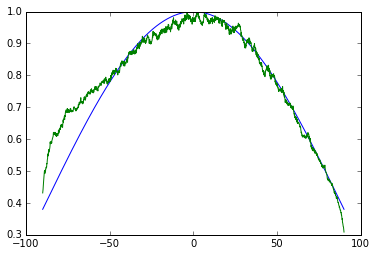

In [151]:
def limb(A, x):
    return (1 +  A*(1 - np.cos(np.deg2rad(x))))
plt.plot( xsundisk, limb(-.62, xsundisk))
plt.plot( xsundisk, sundiskmaksedl1/np.max(sundiskmaksedl1))

We see from the graph above that we can get a good fit of the value $ A = -0.62$